In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
week_nums = [211002,211009,211016,211023,211030,211106,211113,211120,211127,211204,211211,211218,211225]
dfs = []
for week_num in week_nums:
  dfs.append(pd.read_csv(f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{week_num}.txt"))
df = pd.concat(dfs)

In [3]:
from sqlalchemy import create_engine
from sqlalchemy import inspect

In [4]:
engine = create_engine("sqlite:///mta_data.db", pool_pre_ping=True)

In [5]:
!pwd

/Users/kate/Documents/GitHub/NBM_EDA_Student/resources/get_mta


In [6]:
insp = inspect(engine)
print(insp.get_table_names())

['mta_data']


In [7]:
df = pd.read_sql('SELECT * FROM mta_data;', engine)
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270


In [8]:
df.DATE.nunique()


91

In [9]:
#rename columns
df.columns = ['control_area', 'unit','scp', 'station','lines','division','date','time','regular','entries','exits']


In [10]:
#take difference between entries/exits from one four-hour period to the next
df['net_entries'] = df.entries.diff()
df['net_exits'] = df.exits.diff()
df['net_traffic'] = df.entries.diff() + df.exits.diff()

#make datetime one column
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

df.insert(0, 'turnstile', df.control_area + str(' ') + df.unit + str(' ') + df.scp)

#add days of week
from datetime import datetime
df['day_of_week'] = df['datetime'].dt.day_name()

#delete c/a, unit, linename, division, desc
df.drop(['control_area','unit','scp','lines','division','date','time','entries','exits'], axis=1, inplace = True)

In [11]:
#sort by datetime
df.sort_values(by = ['turnstile', 'datetime'])
df[500:510]

,turnstile,station,regular,net_entries,net_exits,net_traffic,datetime,day_of_week
500,A002 R051 02-06-00,59 ST,REGULAR,37.0,10.0,47.0,2021-12-24 11:00:00,Friday
501,A002 R051 02-06-00,59 ST,REGULAR,79.0,10.0,89.0,2021-12-24 15:00:00,Friday
502,A002 R051 02-06-00,59 ST,REGULAR,159.0,22.0,181.0,2021-12-24 19:00:00,Friday
503,A002 R051 02-06-00,59 ST,REGULAR,63.0,7.0,70.0,2021-12-24 23:00:00,Friday
504,A006 R079 00-00-00,5 AV/59 ST,REGULAR,4335499.0,7916600.0,12252099.0,2021-12-18 01:00:00,Saturday
505,A006 R079 00-00-00,5 AV/59 ST,REGULAR,15.0,11.0,26.0,2021-12-18 05:00:00,Saturday
506,A006 R079 00-00-00,5 AV/59 ST,REGULAR,13.0,139.0,152.0,2021-12-18 09:00:00,Saturday
507,A006 R079 00-00-00,5 AV/59 ST,REGULAR,49.0,284.0,333.0,2021-12-18 13:00:00,Saturday
508,A006 R079 00-00-00,5 AV/59 ST,REGULAR,155.0,322.0,477.0,2021-12-18 17:00:00,Saturday
509,A006 R079 00-00-00,5 AV/59 ST,REGULAR,208.0,155.0,363.0,2021-12-18 21:00:00,Saturday


In [12]:
#change all negatibve values to positive
df = df[df.net_traffic >= 0]
df = df[df.turnstile == df.shift(1).turnstile].reset_index(drop = True)
df[500:510]

,turnstile,station,regular,net_entries,net_exits,net_traffic,datetime,day_of_week
500,A006 R079 00-00-00,5 AV/59 ST,REGULAR,108.0,37.0,145.0,2021-12-21 01:00:00,Tuesday
501,A006 R079 00-00-00,5 AV/59 ST,REGULAR,13.0,0.0,13.0,2021-12-21 05:00:00,Tuesday
502,A006 R079 00-00-00,5 AV/59 ST,REGULAR,21.0,387.0,408.0,2021-12-21 09:00:00,Tuesday
503,A006 R079 00-00-00,5 AV/59 ST,REGULAR,60.0,608.0,668.0,2021-12-21 13:00:00,Tuesday
504,A006 R079 00-00-00,5 AV/59 ST,REGULAR,253.0,404.0,657.0,2021-12-21 17:00:00,Tuesday
505,A006 R079 00-00-00,5 AV/59 ST,REGULAR,311.0,185.0,496.0,2021-12-21 21:00:00,Tuesday
506,A006 R079 00-00-00,5 AV/59 ST,REGULAR,124.0,44.0,168.0,2021-12-22 01:00:00,Wednesday
507,A006 R079 00-00-00,5 AV/59 ST,REGULAR,12.0,5.0,17.0,2021-12-22 05:00:00,Wednesday
508,A006 R079 00-00-00,5 AV/59 ST,REGULAR,25.0,320.0,345.0,2021-12-22 09:00:00,Wednesday
509,A006 R079 00-00-00,5 AV/59 ST,REGULAR,80.0,470.0,550.0,2021-12-22 13:00:00,Wednesday


In [13]:
df['net_traffic'].describe()

count    2.611147e+06
mean     7.256129e+03
std      4.071591e+06
min      0.000000e+00
25%      1.800000e+01
50%      8.900000e+01
75%      2.330000e+02
max      3.559561e+09
Name: net_traffic, dtype: float64

In [14]:
#get rid of unreasonably large values
#df.sort_values(by = 'net_traffic', ascending = False)[130:180]
df1 = df.sort_values(by = 'net_traffic', ascending = False)[135:]

In [15]:
#df.sort_values(by = 'net_traffic', ascending = False)[180:230]

#group by daytime - 7am to 9pm?
#df = df[df.identifier == df.shift(1).identifier]
#sort by total traffic

#Check that minimum = 0 and maximum = approximately 3,000
df1['net_traffic'].describe()

count    2.611012e+06
mean     1.627877e+02
std      2.041782e+02
min      0.000000e+00
25%      1.800000e+01
50%      8.900000e+01
75%      2.330000e+02
max      2.961000e+03
Name: net_traffic, dtype: float64

In [16]:
df1.columns

Index(['turnstile', 'station', 'regular', 'net_entries', 'net_exits',
       'net_traffic', 'datetime', 'day_of_week'],
      dtype='object')

In [17]:
#df.sort_values(by = 'net_traffic', ascending = False)[230:280]


#df3 is one row per datetime unit, 4 hour intervals. All turnstiles for one station in 4-hour window.
df3 = df1.groupby(['station','datetime', 'day_of_week'], as_index = False)['net_traffic'].sum().reset_index()
df3 = df3.sort_values('net_traffic', ascending = False)
df3.head(40)

,index,station,datetime,day_of_week,net_traffic
43256,43256,34 ST-PENN STA,2021-11-23 19:00:00,Tuesday,42701.0
41804,41804,34 ST-HERALD SQ,2021-11-24 19:00:00,Wednesday,42081.0
41898,41898,34 ST-HERALD SQ,2021-12-10 19:00:00,Friday,41417.0
41798,41798,34 ST-HERALD SQ,2021-11-23 19:00:00,Tuesday,40842.0
41857,41857,34 ST-HERALD SQ,2021-12-03 19:00:00,Friday,40457.0
41892,41892,34 ST-HERALD SQ,2021-12-09 19:00:00,Thursday,40428.0
41880,41880,34 ST-HERALD SQ,2021-12-07 19:00:00,Tuesday,40140.0
41886,41886,34 ST-HERALD SQ,2021-12-08 19:00:00,Wednesday,40118.0
41939,41939,34 ST-HERALD SQ,2021-12-17 19:00:00,Friday,40009.0
41921,41921,34 ST-HERALD SQ,2021-12-14 19:00:00,Tuesday,39978.0


In [42]:
penn_34th = df1[df1.station == '34 ST-PENN STA'].groupby(['station','datetime', 'day_of_week'], as_index = False)['net_traffic'].sum().reset_index()
#penn_34th = penn_34th.sort_values('net_traffic', ascending = False)
penn_34th.head(30)


#separate time and date from datetime, plot average time and net traffic

,index,station,datetime,day_of_week,net_traffic
0,0,34 ST-PENN STA,2021-09-25 04:00:00,Saturday,1113.0
1,1,34 ST-PENN STA,2021-09-25 06:00:00,Saturday,332.0
2,2,34 ST-PENN STA,2021-09-25 08:00:00,Saturday,3326.0
3,3,34 ST-PENN STA,2021-09-25 10:00:00,Saturday,3274.0
4,4,34 ST-PENN STA,2021-09-25 12:00:00,Saturday,10439.0
5,5,34 ST-PENN STA,2021-09-25 14:00:00,Saturday,6109.0
6,6,34 ST-PENN STA,2021-09-25 16:00:00,Saturday,17002.0
7,7,34 ST-PENN STA,2021-09-25 18:00:00,Saturday,7235.0
8,8,34 ST-PENN STA,2021-09-25 20:00:00,Saturday,16300.0
9,9,34 ST-PENN STA,2021-09-25 22:00:00,Saturday,5331.0


In [18]:
df1.groupby(['station'], as_index = True)['net_traffic'].sum().reset_index()

,station,net_traffic
0,1 AV,2223472.0
1,103 ST,2431611.0
2,103 ST-CORONA,2068937.0
3,104 ST,297752.0
4,110 ST,1011764.0
...,...,...
374,WOODLAWN,404119.0
375,WORLD TRADE CTR,1036001.0
376,WTC-CORTLANDT,818063.0
377,YORK ST,778163.0


In [19]:
#df2 is our data frame grouped by station. One row per station.

df2 = pd.DataFrame(df1.groupby('station')['net_traffic'].sum()).reset_index()
df2.sort_values(by = 'net_traffic', ascending = False, inplace = True)
df2.head()

,station,net_traffic
61,34 ST-PENN STA,11438522.0
233,GRD CNTRL-42 ST,8607911.0
59,34 ST-HERALD SQ,8465231.0
14,14 ST-UNION SQ,7734528.0
110,86 ST,7685949.0


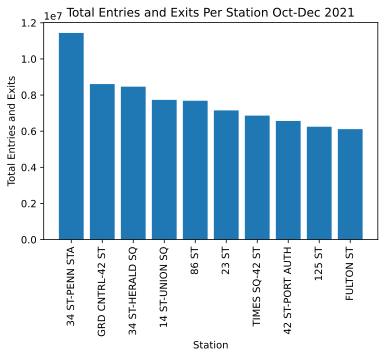

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or retina, enables diff formats, if multiple, uses best
%matplotlib inline

plt.bar(x=df2['station'][:10], height=df2['net_traffic'][:10]) #height is y
plt.xticks(rotation=90);
plt.ylabel("Total Entries and Exits");
plt.xlabel("Station");
plt.title('Total Entries and Exits Per Station Oct-Dec 2021');

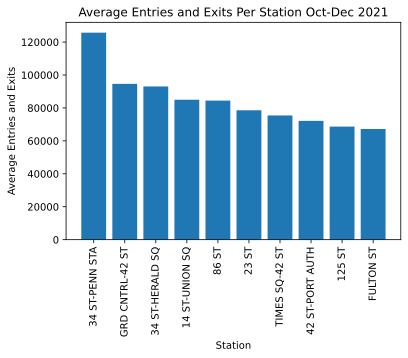

In [21]:
plt.bar(x=df2['station'][:10], height=(df2['net_traffic'] / 91)[:10])
plt.xticks(rotation=90);
plt.ylabel("Average Entries and Exits");
plt.xlabel("Station");
plt.title('Average Entries and Exits Per Station Oct-Dec 2021');

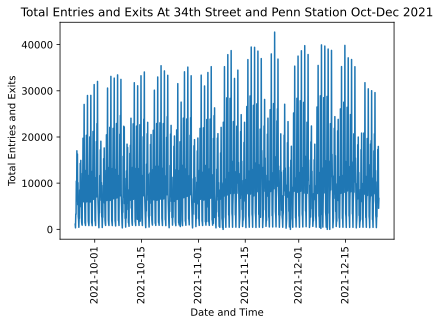

In [47]:
plt.plot(penn_34th['datetime'],penn_34th['net_traffic'])
plt.xticks(rotation=90);
plt.ylabel("Total Entries and Exits");
plt.xlabel("Date and Time");
plt.title('Total Entries and Exits At 34th Street and Penn Station Oct-Dec 2021');

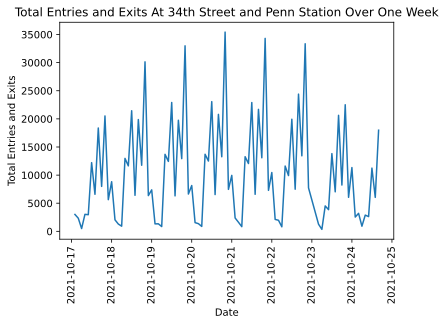

In [57]:
plt.plot(penn_34th['datetime'][260:350],penn_34th['net_traffic'][260:350])
plt.xticks(rotation=90);
plt.ylabel("Total Entries and Exits");
plt.xlabel("Date");
plt.title('Total Entries and Exits At 34th Street and Penn Station Over One Week');